# Poker Agent V7: Long-Term Memory & Outcome Modeling

This notebook implements the V7 architecture designed to solve the "resetting memory" problem of V6. 

### Key Innovations:
1. **Persistent Memory**: The action history is **NOT** cleared between hands. It is a rolling buffer of the last 100 actions/events. This allows the agent to remember opponent behavior from previous hands (e.g., "This player raised 3 times in a row before").
2. **Outcome Awareness**: At the end of each hand, a special **Outcome Token** (WIN/LOSS/TIE) is injected into the history stream. This teaches the LSTM which patterns lead to success and which to failure.
3. **Longer Context**: The LSTM now processes a sequence of 100 tokens (vs 20 in V6) to capture multi-hand dynamics.

### Architecture Diagram
```
State (Cards, Pot)        --> MLP --> Feat1 --\
                                               (+)--> FC -> Q-Values
Long-Term History (Actions + Outcomes) --> LSTM -> Feat2 --/
```

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import random
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict, Any

from pokerkit import Automation, NoLimitTexasHoldem, Card

# Constants
SEED = 42
MAX_HISTORY_LEN = 100  # Increased for multi-hand context
ACTION_EMBED_DIM = 16  # Increased for richer vocabulary
HIDDEN_DIM_LSTM = 128  # Increased capacity
HIDDEN_DIM_MLP = 128

# Action Constants (for env.step)
ENV_FOLD = 0
ENV_CHECK_CALL = 1
ENV_BET_RAISE = 2
NUM_ACTIONS = 3

# Extended History Vocabulary (Tokens)
ACT_PAD = 0
ACT_V_FOLD = 1
ACT_V_CHECK_CALL = 2
ACT_V_BET_RAISE = 3
OPP_FOLD = 4
OPP_CHECK_CALL = 5
OPP_BET_RAISE = 6
# New Outcome Tokens
OUT_AGENT_WIN = 7
OUT_AGENT_LOSS = 8
OUT_TIE = 9
OUT_NEW_HAND = 10
HISTORY_VOCAB_SIZE = 11

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class PersistentPokerEnv(gym.Env):
    """
    Gymnasium wrapper with PERSISTENT history across hands.
    Injects outcome tokens at the end of hands.
    """
    
    def __init__(self, num_players: int = 2, starting_stack: int = 1000, 
                 small_blind: int = 5, big_blind: int = 10):
        super().__init__()
        self.num_players = num_players
        self.starting_stack = starting_stack
        self.small_blind = small_blind
        self.big_blind = big_blind
        
        self.game_state_dim = 52*2 + 52*5 + num_players + 1 + 1 + 4 + 1 
        
        self.observation_space = spaces.Dict({
            'game_state': spaces.Box(low=0, high=1, shape=(self.game_state_dim,), dtype=np.float32),
            'history': spaces.Box(low=0, high=HISTORY_VOCAB_SIZE-1, shape=(MAX_HISTORY_LEN,), dtype=np.int64)
        })
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        self.state = None
        self.agent_player_index = 0
        
        # Persistent History Queue
        self.global_history = deque(maxlen=MAX_HISTORY_LEN)
        # Initialize with pads
        for _ in range(MAX_HISTORY_LEN):
            self.global_history.append(ACT_PAD)
        
    def _card_to_index(self, card: Card) -> int:
        ranks = '23456789TJQKA'
        suits = 'cdhs'
        rank_idx = ranks.index(card.rank)
        suit_idx = suits.index(card.suit)
        return rank_idx * 4 + suit_idx
    
    def _encode_card(self, card: Optional[Card]) -> np.ndarray:
        encoding = np.zeros(52, dtype=np.float32)
        if card is not None:
            encoding[self._card_to_index(card)] = 1.0
        return encoding
    
    def _flatten_cards(self, cards) -> List:
        flat = []
        for item in cards:
            if hasattr(item, 'rank'):
                flat.append(item)
            else:
                flat.extend(self._flatten_cards(item))
        return flat
    
    def _get_observation(self) -> Dict[str, Any]:
        state_vector = []
        hole_cards = self._flatten_cards(self.state.hole_cards[self.agent_player_index])
        for i in range(2):
            if i < len(hole_cards):
                state_vector.extend(self._encode_card(hole_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        board_cards = self._flatten_cards(self.state.board_cards)
        for i in range(5):
            if i < len(board_cards):
                state_vector.extend(self._encode_card(board_cards[i]))
            else:
                state_vector.extend(np.zeros(52, dtype=np.float32))
        
        for i in range(self.num_players):
            stack = self.state.stacks[i] / self.starting_stack
            state_vector.append(min(stack, 2.0))
        
        total_pot = sum(self.state.bets)
        state_vector.append(total_pot / (self.starting_stack * self.num_players))
        
        if self.state.actor_index is not None:
            state_vector.append(self.state.actor_index / max(1, self.num_players - 1))
        else:
            state_vector.append(0.0)
        
        street = [0.0, 0.0, 0.0, 0.0]
        num_board = len(board_cards)
        if num_board == 0: street[0] = 1.0
        elif num_board == 3: street[1] = 1.0
        elif num_board == 4: street[2] = 1.0
        else: street[3] = 1.0
        state_vector.extend(street)
        state_vector.append(float(self.agent_player_index))

        # Return global persistent history
        return {
            'game_state': np.array(state_vector, dtype=np.float32),
            'history': np.array(list(self.global_history), dtype=np.int64)
        }
    
    def _update_history(self, player_idx: int, action: int):
        if player_idx == self.agent_player_index:
            if action == ENV_FOLD: token = ACT_V_FOLD
            elif action == ENV_CHECK_CALL: token = ACT_V_CHECK_CALL
            else: token = ACT_V_BET_RAISE
        else:
            if action == ENV_FOLD: token = OPP_FOLD
            elif action == ENV_CHECK_CALL: token = OPP_CHECK_CALL
            else: token = OPP_BET_RAISE
        self.global_history.append(token)

    def append_outcome_token(self, final_reward: float):
        """Inject Win/Loss outcome into history"""
        if final_reward > 0:
            self.global_history.append(OUT_AGENT_WIN)
        elif final_reward < 0:
            self.global_history.append(OUT_AGENT_LOSS)
        else:
            self.global_history.append(OUT_TIE)

    def _get_legal_actions(self) -> List[int]:
        legal = []
        if self.state.can_fold(): legal.append(ENV_FOLD)
        if self.state.can_check_or_call(): legal.append(ENV_CHECK_CALL)
        if self.state.can_complete_bet_or_raise_to(): legal.append(ENV_BET_RAISE)
        return legal if legal else [ENV_CHECK_CALL]
    
    def _execute_action(self, action: int) -> None:
        if action == ENV_FOLD:
            if self.state.can_fold(): self.state.fold()
            elif self.state.can_check_or_call(): self.state.check_or_call()
        elif action == ENV_CHECK_CALL:
            if self.state.can_check_or_call(): self.state.check_or_call()
            elif self.state.can_fold(): self.state.fold()
        elif action == ENV_BET_RAISE:
            if self.state.can_complete_bet_or_raise_to():
                min_r = self.state.min_completion_betting_or_raising_to_amount
                max_r = self.state.max_completion_betting_or_raising_to_amount
                self.state.complete_bet_or_raise_to(min(min_r * 2, max_r))
            elif self.state.can_check_or_call():
                self.state.check_or_call()
    
    def _run_automations(self) -> None:
        while self.state.can_burn_card(): self.state.burn_card('??')
        while self.state.can_deal_board(): self.state.deal_board()
        while self.state.can_push_chips(): self.state.push_chips()
        while self.state.can_pull_chips(): self.state.pull_chips()
    
    def reset(self, seed=None, options=None) -> Tuple[Dict, Dict]:
        # NOTE: We do NOT clear global_history here. 
        # We force a NEW_HAND token to mark separation.
        self.global_history.append(OUT_NEW_HAND)
        
        super().reset(seed=seed)
        self.state = NoLimitTexasHoldem.create_state(
            automations=(Automation.ANTE_POSTING, Automation.BET_COLLECTION, Automation.BLIND_OR_STRADDLE_POSTING, Automation.HOLE_CARDS_SHOWING_OR_MUCKING, Automation.HAND_KILLING, Automation.CHIPS_PUSHING, Automation.CHIPS_PULLING),
            ante_trimming_status=True,
            raw_antes={-1: 0},
            raw_blinds_or_straddles=(self.small_blind, self.big_blind),
            min_bet=self.big_blind,
            raw_starting_stacks=[self.starting_stack] * self.num_players,
            player_count=self.num_players,
        )
        while self.state.can_deal_hole(): self.state.deal_hole()
        self._run_automations()
        return self._get_observation(), {'legal_actions': self._get_legal_actions()}
    
    def step(self, action: int) -> Tuple[Dict, float, bool, bool, Dict]:
        if self.state.actor_index is not None:
             self._update_history(self.state.actor_index, action)
        self._execute_action(action)
        self._run_automations()
        done = self.state.status is False
        reward = 0.0
        if done:
            reward = (self.state.stacks[self.agent_player_index] - self.starting_stack) / self.big_blind
        obs = self._get_observation()
        info = {'legal_actions': self._get_legal_actions() if not done else []}
        return obs, reward, done, False, info

    def get_final_reward(self) -> float:
        return (self.state.stacks[self.agent_player_index] - self.starting_stack) / self.big_blind
    
    def update_opponent_history(self, action: int):
        opp_idx = 1 - self.agent_player_index
        self._update_history(opp_idx, action)

In [4]:
class DualBranchV7(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.state_net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.action_embedding = nn.Embedding(HISTORY_VOCAB_SIZE, ACTION_EMBED_DIM)
        # LSTM hidden size increased for longer sequences
        self.lstm = nn.LSTM(input_size=ACTION_EMBED_DIM, hidden_size=HIDDEN_DIM_LSTM, batch_first=True)
        self.value_head = nn.Sequential(
            nn.Linear(128 + HIDDEN_DIM_LSTM, 256), nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        
    def forward(self, state, history):
        s_feat = self.state_net(state)
        h_embed = self.action_embedding(history)
        lstm_out, (hn, cn) = self.lstm(h_embed)
        h_context = hn[-1]
        combined = torch.cat([s_feat, h_context], dim=1)
        return self.value_head(combined)

class ReplayBufferV7:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    def push(self, transition):
        self.buffer.append(transition)
    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))
    def __len__(self): return len(self.buffer)

class AdaptiveAgentV7:
    def __init__(self, state_dim, action_dim=NUM_ACTIONS, lr=1e-4):
        self.model = DualBranchV7(state_dim, action_dim).to(device)
        self.target_model = DualBranchV7(state_dim, action_dim).to(device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99995
        
    def select_action(self, obs, legal_actions, eval_mode=False):
        if not eval_mode and random.random() < self.epsilon:
            return random.choice(legal_actions)
        state_t = torch.FloatTensor(obs['game_state']).unsqueeze(0).to(device)
        h_t = torch.LongTensor(obs['history']).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.model(state_t, h_t)
        q_numpy = q_values.cpu().numpy().flatten()
        masked_q = np.full(NUM_ACTIONS, -np.inf)
        for a in legal_actions: masked_q[a] = q_numpy[a]
        return int(np.argmax(masked_q))

    def train(self, buffer, batch_size=64):
        if len(buffer) < batch_size: return None
        batch = buffer.sample(batch_size)
        states = torch.FloatTensor(np.array([t[0] for t in batch])).to(device)
        histories = torch.LongTensor(np.array([t[1] for t in batch])).to(device)
        actions = torch.LongTensor(np.array([t[2] for t in batch])).to(device)
        rewards = torch.FloatTensor(np.array([t[3] for t in batch])).to(device)
        next_states = torch.FloatTensor(np.array([t[4] for t in batch])).to(device)
        next_histories = torch.LongTensor(np.array([t[5] for t in batch])).to(device)
        dones = torch.FloatTensor(np.array([t[6] for t in batch])).to(device)
        
        current_q = self.model(states, histories).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_actions = self.model(next_states, next_histories).argmax(1).unsqueeze(1)
            target_q_next = self.target_model(next_states, next_histories).gather(1, next_actions).squeeze(1)
            target = rewards + (1 - dones) * self.gamma * target_q_next
        loss = F.mse_loss(current_q, target)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()
        return loss.item()
    
    def update_target(self): self.target_model.load_state_dict(self.model.state_dict())

In [5]:
class ManiacAgent:
    def select_action(self, legal_actions):
        if ENV_BET_RAISE in legal_actions: return ENV_BET_RAISE
        if ENV_CHECK_CALL in legal_actions: return ENV_CHECK_CALL
        return ENV_FOLD
class NitAgent:
    def select_action(self, legal_actions):
        if ENV_FOLD in legal_actions and ENV_CHECK_CALL in legal_actions:
            if random.random() < 0.9: return ENV_FOLD
        if ENV_CHECK_CALL in legal_actions: return ENV_CHECK_CALL
        return ENV_FOLD
class RandomAgent:
    def select_action(self, legal_actions): return random.choice(legal_actions)

Training V7 for 50000 hands against MIXED opponents (Persistent Memory)...

=== Training Checkpoint: Hand 2000 ===
Vs Maniac: Avg -11.91 BB/hand | Win Rate 8.0%
Vs Nit: Avg 0.55 BB/hand | Win Rate 99.3%
Vs Random: Avg 2.47 BB/hand | Win Rate 65.2%
Epsilon: 0.90

=== Training Checkpoint: Hand 4000 ===
Vs Maniac: Avg -9.58 BB/hand | Win Rate 8.8%
Vs Nit: Avg 0.57 BB/hand | Win Rate 99.4%
Vs Random: Avg 0.29 BB/hand | Win Rate 65.9%
Epsilon: 0.82

=== Training Checkpoint: Hand 6000 ===
Vs Maniac: Avg -5.00 BB/hand | Win Rate 8.7%
Vs Nit: Avg 0.50 BB/hand | Win Rate 99.3%
Vs Random: Avg -1.77 BB/hand | Win Rate 64.8%
Epsilon: 0.74

=== Training Checkpoint: Hand 8000 ===
Vs Maniac: Avg -7.62 BB/hand | Win Rate 8.0%
Vs Nit: Avg 0.55 BB/hand | Win Rate 99.2%
Vs Random: Avg 0.48 BB/hand | Win Rate 64.1%
Epsilon: 0.67

=== Training Checkpoint: Hand 10000 ===
Vs Maniac: Avg -7.67 BB/hand | Win Rate 7.5%
Vs Nit: Avg 0.53 BB/hand | Win Rate 98.8%
Vs Random: Avg -1.29 BB/hand | Win Rate 62.7%
Epsil

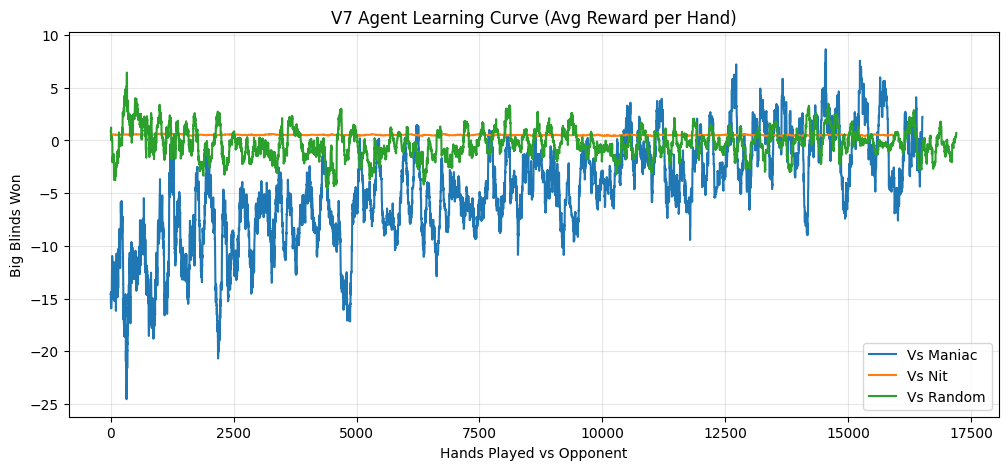

<Figure size 640x480 with 0 Axes>

In [7]:
def train_v7(num_hands=30000):
    env = PersistentPokerEnv()
    agent = AdaptiveAgentV7(env.game_state_dim)
    buffer = ReplayBufferV7(capacity=50000)
    opponents = [ManiacAgent(), NitAgent(), RandomAgent()]
    opp_names = ['Maniac', 'Nit', 'Random']
    
    stats = {
        'Maniac': {'rewards': [], 'wins': 0, 'hands': 0},
        'Nit': {'rewards': [], 'wins': 0, 'hands': 0},
        'Random': {'rewards': [], 'wins': 0, 'hands': 0}
    }
    
    print(f"Training V7 for {num_hands} hands against MIXED opponents (Persistent Memory)...")
    
    # To enable memory persistence, we will switch opponents every 10 hands
    # This forces the agent to learn "This 10 hand block is Maniac"
    current_opp_idx = 0
    
    for hand in range(num_hands):
        # Switch opponent every 10 hands to build detectable history patterns
        if hand % 10 == 0:
            current_opp_idx = random.randint(0, 2)
            
        opponent = opponents[current_opp_idx]
        opp_name = opp_names[current_opp_idx]
        
        obs, info = env.reset()
        done = False
        episode_transitions = []
        pending_agent_obs = None
        pending_agent_action = None
        
        while not done:
            if env.state.actor_index == env.agent_player_index:
                if pending_agent_obs is not None:
                    episode_transitions.append((pending_agent_obs['game_state'], pending_agent_obs['history'], pending_agent_action, 0.0, obs['game_state'], obs['history'], False, info['legal_actions']))
                
                action = agent.select_action(obs, info['legal_actions'])
                pending_agent_obs = obs
                pending_agent_action = action
                obs, reward, done, _, info = env.step(action)
                
                if done:
                    # Don't record terminal yet, wait for reward injection
                    pass
            else:
                action = opponent.select_action(info['legal_actions'])
                env.update_opponent_history(action)
                env._execute_action(action)
                env._run_automations()
                done = env.state.status is False
                if not done:
                    obs = env._get_observation()
                    info['legal_actions'] = env._get_legal_actions()
        
        final_reward = env.get_final_reward()
        
        # CRITICAL V7: Inject Outcome Token BEFORE recording terminal state
        env.append_outcome_token(final_reward)
        
        # Now grab terminal obs which includes the outcome token in history
        term_obs = env._get_observation()
        
        # Record last transition pointing to this outcome-enriched terminal state
        if pending_agent_obs is not None:
             episode_transitions.append((pending_agent_obs['game_state'], pending_agent_obs['history'], pending_agent_action, 0.0, term_obs['game_state'], term_obs['history'], True, []))
        
        # Update Stats
        stats[opp_name]['rewards'].append(final_reward)
        stats[opp_name]['hands'] += 1
        if final_reward > 0: stats[opp_name]['wins'] += 1
        
        # Buffer Push (Mont Carlo Returns)
        for i in range(len(episode_transitions)):
            s, h, a, r, ns, nh, d, l = episode_transitions[i]
            buffer.push((s, h, a, final_reward, ns, nh, d, l))
            
        if len(buffer) > 1000:
            agent.train(buffer)
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        if hand % 500 == 0: agent.update_target()
        
        # Explicit Logging every 2000 hands
        if hand % 2000 == 0 and hand > 0:
            print(f"\n=== Training Checkpoint: Hand {hand} ===")
            for name in opp_names:
                d = stats[name]
                if d['hands'] > 0:
                    recent_r = np.mean(d['rewards'][-200:])
                    win_rate = d['wins'] / d['hands']
                    print(f"Vs {name}: Avg {recent_r:.2f} BB/hand | Win Rate {win_rate:.1%}")
            print(f"Epsilon: {agent.epsilon:.2f}")
            
    return agent, stats

def plot_results(stats):
    plt.figure(figsize=(12, 5))
    for name, data in stats.items():
        # Moving average of rewards
        rewards = data['rewards']
        if len(rewards) > 100:
            ma = np.convolve(rewards, np.ones(100)/100, mode='valid')
            plt.plot(ma, label=f"Vs {name}")
    plt.title("V7 Agent Learning Curve (Avg Reward per Hand)")
    plt.xlabel("Hands Played vs Opponent")
    plt.ylabel("Big Blinds Won")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    plt.savefig("v7_training_results.png")

agent, stats = train_v7(50000)
plot_results(stats)